<a href="https://colab.research.google.com/github/Iguta/ZTM-DeepLearningWithPyTorch/blob/main/Neural_Network_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural network classification with Pytorch

In [1568]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import pandas as pd

In [1569]:
#make 1000 samples
n_samples  = 1000

#create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)
len(X), len(y)

(1000, 1000)

In [1570]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [1571]:
df = pd.DataFrame({"X1": X[:, 0],
                   "X2":X[:,1],
                   "label":y},
                  )
df.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [1572]:
df["label"].value_counts()

,count
label,
1,500
0,500


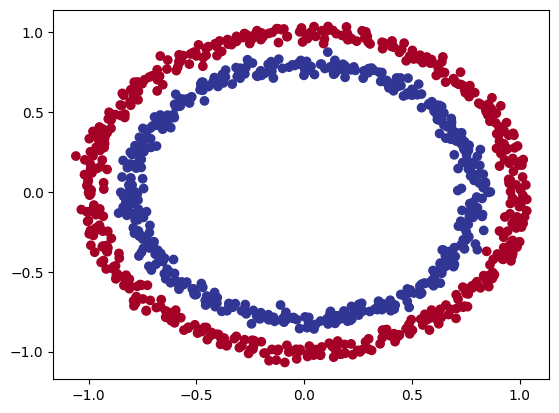

In [1573]:
#visualize
plt.scatter(df["X1"],
            df["X2"],
            c=y,
            cmap=plt.cm.RdYlBu
            )

### Check input and output shapes

In [1574]:
X.shape, y.shape

((1000, 2), (1000,))

In [1575]:
#turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [1576]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [1577]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [1578]:
len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

### Building a model

In [1579]:
#device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [1580]:
class nnClassification(nn.Module):
  def __init__(self):
    super().__init__()
    # create nn.Linear layers capable of handling the shape of our data
    # self.input_layer = nn.Linear(1, 10) # for experimentation
    self.input_layer = nn.Linear(2, 10) #takes 2 features and upscales 10 features
    self.hidden_layer = nn.Linear(10, 10) #takes 10 features and outputs 10 feature
    self.output_layer = nn.Linear(10, 1)


  def forward(self, x):
    out = self.input_layer(x)
    out = self.hidden_layer(out)
    out = self.output_layer(out)

    return out


In [1581]:
#instantiate our model
model =nnClassification().to(device)
next(model.parameters()).device

device(type='cuda', index=0)

In [1582]:
model.parameters()

<generator object Module.parameters at 0x7ace0c997ae0>

### Loss function and the optimizer

In [1583]:
loss_fn = nn.BCEWithLogitsLoss() #BCEWithLogitsLoss = sigmoid activation function built-in
# loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.01)

In [1584]:
# model.state_dict()

In [1585]:
def accuracy(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## Train Model
1. Forward pass
2. Calculate the loss
3. Optimize zero grad
4. Backpropagation
5. Optimize step(gradient descent)

In [1586]:
type(X_test)
model

nnClassification(
  (input_layer): Linear(in_features=2, out_features=10, bias=True)
  (hidden_layer): Linear(in_features=10, out_features=10, bias=True)
  (output_layer): Linear(in_features=10, out_features=1, bias=True)
)

In [1587]:
#view the logits - raw values of our forward pass before we pass them to
#some activation function such as sigmoid (binary) or cross-entropy
model.eval()
with torch.inference_mode():
  y_logits = model(X_test.to(device))[:5]
y_logits[:5]

tensor([[-0.1918],
        [-0.2042],
        [-0.0260],
        [-0.2394],
        [ 0.1857]], device='cuda:0')

In [1588]:
#use the sigmoid activation function
y_probs = torch.sigmoid(y_logits)
y_probs

tensor([[0.4522],
        [0.4491],
        [0.4935],
        [0.4404],
        [0.5463]], device='cuda:0')

In [1589]:
#convert this to labels
y_labels = torch.round(y_probs)
y_labels

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [1.]], device='cuda:0')

In [1590]:
#check for equalitty
print(torch.eq(y_test.squeeze().to(device)[:5], y_labels.squeeze().to(device)[:5]))
print(y_test.squeeze()[:5])

tensor([False,  True, False,  True,  True], device='cuda:0')
tensor([1., 0., 1., 0., 1.])


### Building the Training Loop

In [1591]:
#number of epochs
epochs = 500

#track both training and test loss
train_loss_hist = []
test_loss_hist = []
train_acc_hist = []
test_acc_hist = []

def train(X_train, y_train, X_test, y_test):
  X_train = X_train.to(device)
  y_train = y_train.to(device)
  X_test = X_test.to(device)
  y_test = y_test.to(device)
  for epoch in range(epochs):
    #turn on train mode for our model
    model.train()

    #forward pass -> sigmoid function -> and then range-round to get labels
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    # print(y_pred[:5])

    #calculate loss -> we use BCE Loss here since we have probabilities and not logits
    loss = loss_fn(y_logits, y_train)

    #calculate accuracy
    acc = accuracy(y_train,y_pred)

    #zero grad
    optimizer.zero_grad()

    #perform backpropagation
    loss.backward()

    #optimize the gradients
    optimizer.step()

    #evaluate the model
    model.eval()
    with torch.inference_mode():
      test_logits = model(X_test).squeeze()
      y_labels = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_accuracy = accuracy(y_test, y_labels)
    #append train and test loss
    train_loss_hist.append(loss.item())
    test_loss_hist.append(test_loss.item())
    train_acc_hist.append(acc)
    test_acc_hist.append(test_accuracy)

    #show the progress of training
    if epoch%10 == 0:
      print(f"Epoch {epoch} | Train Loss: {loss.item():.5f} | Test Loss {test_loss.item():.5f} | Train Accuracy {acc:.2f}% | Test Accuracy {test_accuracy:.2f}%")
  return train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist


In [1592]:
len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

In [1593]:
X_train.ndim, X_test.ndim, y_train.ndim, y_test.ndim

(2, 2, 1, 1)

In [1594]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

In [1595]:
train_loss, test_loss, train_acc, test_acc =train(X_train, y_train, X_test, y_test)

Epoch 0 | Train Loss: 0.69679 | Test Loss 0.69268 | Train Accuracy 49.62% | Test Accuracy 48.50%
Epoch 10 | Train Loss: 0.69671 | Test Loss 0.69269 | Train Accuracy 49.50% | Test Accuracy 49.00%
Epoch 20 | Train Loss: 0.69663 | Test Loss 0.69269 | Train Accuracy 49.62% | Test Accuracy 49.00%
Epoch 30 | Train Loss: 0.69656 | Test Loss 0.69270 | Train Accuracy 49.38% | Test Accuracy 49.00%
Epoch 40 | Train Loss: 0.69648 | Test Loss 0.69270 | Train Accuracy 49.38% | Test Accuracy 50.00%
Epoch 50 | Train Loss: 0.69641 | Test Loss 0.69271 | Train Accuracy 49.38% | Test Accuracy 50.00%
Epoch 60 | Train Loss: 0.69634 | Test Loss 0.69271 | Train Accuracy 49.25% | Test Accuracy 50.00%
Epoch 70 | Train Loss: 0.69627 | Test Loss 0.69272 | Train Accuracy 49.38% | Test Accuracy 50.00%
Epoch 80 | Train Loss: 0.69621 | Test Loss 0.69273 | Train Accuracy 49.62% | Test Accuracy 50.50%
Epoch 90 | Train Loss: 0.69614 | Test Loss 0.69273 | Train Accuracy 49.62% | Test Accuracy 50.50%
Epoch 100 | Train Los

In [1596]:
x =  torch.arange(0, 10, 1)
x.shape

torch.Size([10])

In [1597]:
df["label"].value_counts()

,count
label,
1,500
0,500


### Make Predictions
-> plot decision_boundary()

In [1598]:
import requests
from pathlib import Path


In [1599]:
#download helper function from Learn Pytorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists


In [1600]:
from helper_functions import plot_predictions, plot_decision_boundary

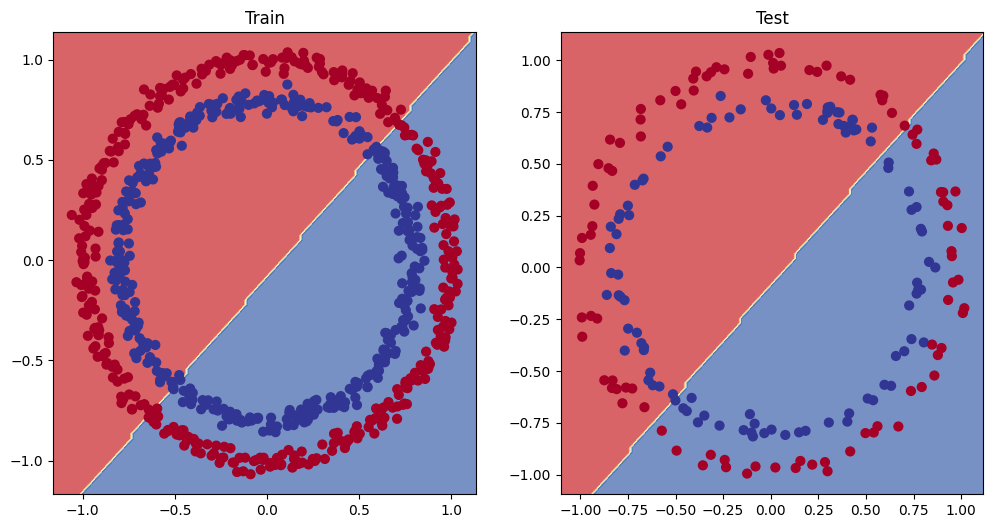

In [1601]:
#plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model,X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

### Improving a Model (potential ways)
1. Add more layers -> to give the model a chance to learn the patterns in the data
2. Add more units per layer
3. Train longer (more epochs)
4. Changing activation functions (sigmoid)
5. Change learning rate (amount the optimizer will change the learnable parameters)
6. Change the loss function (BCE here is pretty standard though)
7. Improve through experimentation

### Test our model is learning
One wat to troubleshoot a larger problem is to test out a smaller problem, and see if our model can learn that


In [1602]:
#create some data
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

#create data
X_regression = torch.arange(start, end, step)
y_regression = weight * X_regression + bias

X_regression[:5], y_regression[:5]


(tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400]),
 tensor([0.3000, 0.3070, 0.3140, 0.3210, 0.3280]))

In [1603]:
#create train and test splits
X_train, X_test, y_train, y_test = train_test_split(X_regression, y_regression)
len(X_train), len(y_train)

(75, 75)

In [1604]:
X_test.shape

torch.Size([25])

In [1605]:
next(model.parameters()).device

device(type='cpu')

In [1606]:
model_2 = nn.Sequential(
    nn.Linear(1, 10),
    nn.Linear(10, 10),
    nn.Linear(10, 1)
).to(device)

In [1607]:
#loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.01)

<Figure size 500x600 with 0 Axes>

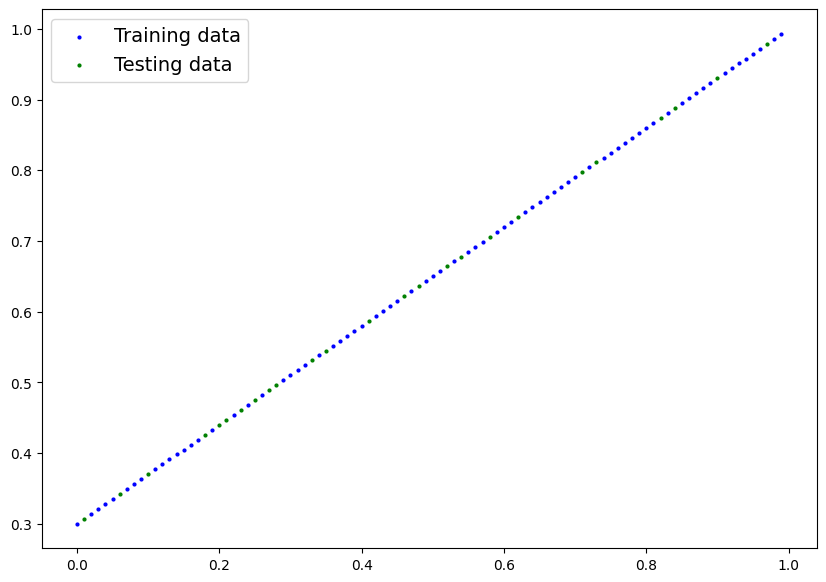

In [1608]:
plt.figure(figsize=(5, 6))
plot_predictions(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu())
plt.show()

In [1609]:
X_train.unsqueeze(dim=0).shape

torch.Size([1, 75])

In [1610]:
#training loop
def train_model(X_train, y_train, X_test, y_test):
  #number of epochs
  epochs = 100

  #track accuracy, train loss and test loss
  train_acc_hist = []
  test_acc_hist = []
  train_loss_hist = []
  test_loss_hist = []

  #run device agnostic for all the tensors to ensure they all in the same device
  X_train = X_train.to(device).unsqueeze(dim=1)
  # print(X_train.shape)
  y_train = y_train.to(device)
  X_test = X_test.to(device).unsqueeze(dim=1)
  y_test = y_test.to(device)

  for epoch in range(epochs):
    #set model for training
    model_2.train()
    # print(X_train[:5])
    #forward pass
    y_pred = model_2(X_train).squeeze()
    # print(y_pred_logits[:1])


    #compute loss
    loss = loss_fn(y_pred, y_train)

    #zero grad
    optimizer.zero_grad()

    #backward propagation
    loss.backward()

    #update parameters
    optimizer.step()

    #evaluate train accuracy
    # train_acc = accuracy(y_train, y_pred)

    #evaluate model
    model_2.eval()
    with torch.inference_mode():
      y_labels = model_2(X_test).squeeze()
      test_loss = loss_fn(y_labels, y_test)
      # test_acc = accuracy(y_test, y_labels)
      # print(y_test, y_labels)

    #append accuracy and loss
    # train_acc_hist.append(train_acc)
    # test_acc_hist.append(test_acc)
    train_loss_hist.append(loss.item())
    test_loss_hist.append(test_loss)

    #visualize the results
    if epoch %10 ==0:
      print(f"Train Loss: {loss.item():.5f} | Test Loss: {test_loss.item():.5f}")
      # print(y_labels)
  return train_loss_hist, test_loss_hist


In [1611]:
train_loss, test_loss = train_model(X_train, y_train, X_test, y_test)

Train Loss: 0.57539 | Test Loss: 0.47279
Train Loss: 0.31165 | Test Loss: 0.23027
Train Loss: 0.23565 | Test Loss: 0.19874
Train Loss: 0.21321 | Test Loss: 0.19194
Train Loss: 0.19933 | Test Loss: 0.18575
Train Loss: 0.18731 | Test Loss: 0.17571
Train Loss: 0.17544 | Test Loss: 0.16609
Train Loss: 0.16359 | Test Loss: 0.15566
Train Loss: 0.15166 | Test Loss: 0.14418
Train Loss: 0.13948 | Test Loss: 0.13250


In [1612]:
X_test[:2]

tensor([0.8200, 0.2700])

In [1613]:
model_2.eval()
with torch.inference_mode():
  predictions = model_2(X_test.unsqueeze(dim=1).to(device))

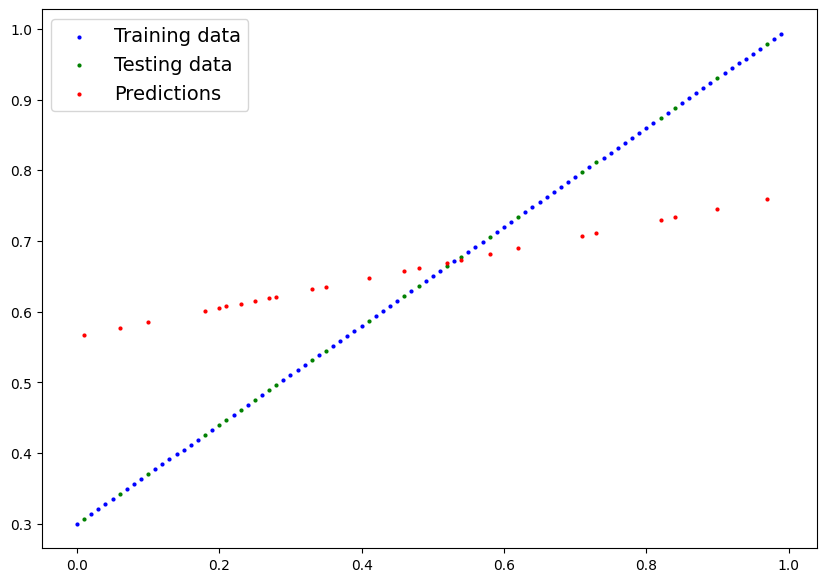

In [1614]:
plot_predictions(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu(), predictions.cpu())

------> so our model is learning something...
The key thing here is non-linearity

In [1615]:
#make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42
                    )

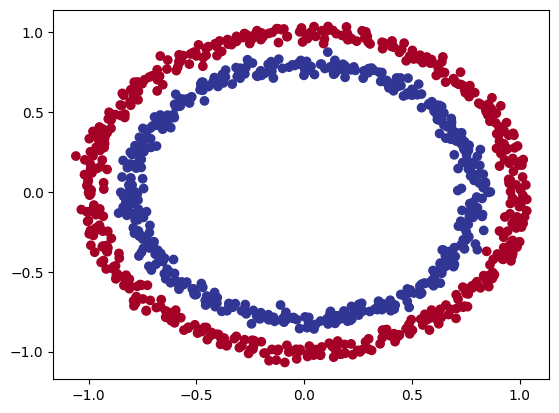

In [1616]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [1617]:
#convert data to tensors and then train and test splits
import torch
from torch import nn

from sklearn.model_selection import train_test_split

#turn data into tensors
X= torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)


In [1618]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [1619]:
len(X_train), len(y_train)

(750, 750)

### Building the model with non-linearity

In [1620]:
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(2, 10),
      nn.ReLU(),
      nn.Linear(10, 10),
      nn.ReLU(), #non-linear activation function
      # nn.Dropout(0.1),
      nn.Linear(10, 1)
    )


  def forward(self, x):
    return self.layers(x)

In [1621]:
model3 = CircleModel().to(device)
model3

CircleModel(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

### Training and Evaluating our non-linear Model

In [1622]:
## loss function
loss_fn = nn.BCEWithLogitsLoss()

## Optimization
optimizer = torch.optim.SGD(
    params=model3.parameters(), lr=0.1)

In [1623]:

def train(X_train, y_train, X_test, y_test):
  #number of epochs
  epochs = 1000

  #track accuracy, training loss and test loss
  train_acc_hist = []
  test_acc_hist = []
  train_loss_hist = []
  test_loss_hist = []

  for epoch in range(epochs):
    #set model to train mode
    model3.train()

    # print(X_train[:5])
    #forward pass
    y_pred_logits = model3(X_train).squeeze()
    # print(type(y_pred_logits))
    #get the probabilities -> labels
    y_pred_labels = torch.round(torch.sigmoid(y_pred_logits))

    #evaluate the training loss
    loss = loss_fn(y_pred_logits, y_train)

    #train accuracy
    train_acc = accuracy(y_train, y_pred_labels)

    #optimizer zero grad
    optimizer.zero_grad()

    #backpropagation
    loss.backward()

    #update the parameters
    optimizer.step()

    #evaluate the model
    model3.eval()
    with torch.inference_mode():
      y_test_logits = model3(X_test).squeeze()
      y_test_labels = torch.round(torch.sigmoid(y_test_logits))
      test_loss = loss_fn(y_test_logits, y_test)
      test_acc = accuracy(y_test, y_test_labels)


    #append loss and accuracy
    train_loss_hist.append(loss.item())
    test_loss_hist.append(test_loss.item())
    train_acc_hist.append(train_acc)
    test_acc_hist.append(test_acc)

    #print the results
    if epoch%100 == 0:
      print(f"Epoch {epoch:} || Train loss: {loss.item():.5f} | Test Loss: {test_loss.item():.5f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")
  return train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist


In [1624]:
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)
train_loss, test_loss, train_acc, test_acc = train(X_train, y_train, X_test, y_test)

Epoch 0 || Train loss: 0.69710 | Test Loss: 0.69677 | Train Acc: 49.87% | Test Acc: 50.40%
Epoch 100 || Train loss: 0.69144 | Test Loss: 0.69242 | Train Acc: 51.87% | Test Acc: 49.20%
Epoch 200 || Train loss: 0.68926 | Test Loss: 0.69048 | Train Acc: 56.40% | Test Acc: 53.60%
Epoch 300 || Train loss: 0.68702 | Test Loss: 0.68879 | Train Acc: 57.47% | Test Acc: 56.40%
Epoch 400 || Train loss: 0.68394 | Test Loss: 0.68642 | Train Acc: 61.73% | Test Acc: 62.40%
Epoch 500 || Train loss: 0.67949 | Test Loss: 0.68265 | Train Acc: 68.67% | Test Acc: 68.40%
Epoch 600 || Train loss: 0.67265 | Test Loss: 0.67644 | Train Acc: 71.73% | Test Acc: 73.20%
Epoch 700 || Train loss: 0.65938 | Test Loss: 0.66303 | Train Acc: 73.87% | Test Acc: 74.00%
Epoch 800 || Train loss: 0.63474 | Test Loss: 0.63807 | Train Acc: 80.80% | Test Acc: 80.00%
Epoch 900 || Train loss: 0.58611 | Test Loss: 0.58859 | Train Acc: 92.67% | Test Acc: 91.60%


In [1625]:
len(X_train), len(y_train), len(X_test), len(y_test)
y.shape

torch.Size([1000])

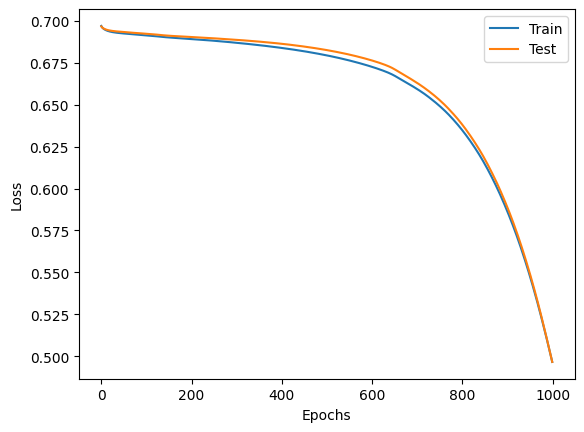

In [1626]:
model.eval()
with torch.inference_mode():
  y_test_labels = model3(X_test).cpu()

plt.plot(train_loss, label="Train")
plt.plot(test_loss, label="Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

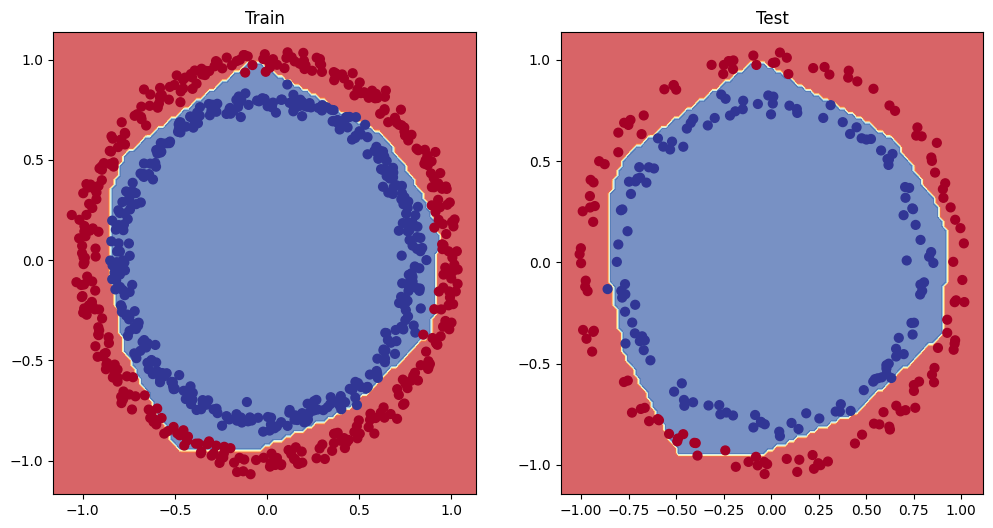

In [1627]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model3, X_test, y_test)